 # SQM for PiFinder

## Load dependencies

In [1]:
!!pip install matplotlib
!!pip install pandas tarfile
from PIL import Image
import os
import sys
import numpy as np
import logging as logger
from pathlib import Path
import matplotlib.pyplot as plt
%matplotlib inline
import pprint
pp = pprint.PrettyPrinter(depth=5)


## Init Cedar and tetra3

In [2]:
os.chdir('/Users/mike/dev/amateur_astro/myPiFinder/wt-sqm/python')
cwd = Path(os.getcwd())
print(cwd)
tetra3_path = cwd / "PiFinder/tetra3/tetra3"
root_path = cwd / '..'

# Add it only once if it's not already there
if str(tetra3_path) not in sys.path:
    sys.path.append(str(tetra3_path))

# Silence tetra3 DEBUG output BEFORE importing tetra3
import logging
logging.basicConfig(level=logging.WARNING)
logging.getLogger('tetra3.Tetra3').setLevel(logging.WARNING)
logging.getLogger('Solver').setLevel(logging.WARNING)

# Now try importing
from breadth_first_combinations import breadth_first_combinations


import PiFinder.tetra3.tetra3 as tetra3
from PiFinder.tetra3.tetra3 import cedar_detect_client
from PiFinder import utils
os_detail, platform, arch = utils.get_os_info()

t3 = tetra3.Tetra3(
    str(tetra3_path / "data/default_database.npz")
)

logger.info("Starting Solver Loop")
# Start cedar detect server
try:
    cedar_detect = cedar_detect_client.CedarDetectClient(
        binary_path=str(root_path / f"bin/cedar-detect-server-{arch}")
    )
except FileNotFoundError as e:
    logger.warn(
        "Not using cedar_detect, as corresponding file '%s' could not be found",
        e.filename,
    )
    cedar_detect = None

/Users/mike/dev/amateur_astro/myPiFinder/wt-sqm/python


[2025-10-31T17:38:38Z INFO  cedar_detect_server] CedarDetectServer listening on 0.0.0.0:50051
Error: tonic::transport::Error(Transport, hyper::Error(Listen, Os { code: 48, kind: AddrInUse, message: "Address already in use" }))


## Import Production SQM Implementation

Using the fixed production code from `PiFinder.sqm`

In [3]:
# Import the production SQM implementation
from PiFinder.sqm import SQM

# Instantiate
sqm = SQM(pedestal_from_background=True)

## Test images

### define test images

In [4]:
images = {
    'sqm1833.png': {'realsqm': 18.33},
    'sqm1837.png': {'realsqm': 18.37},
    'sqm1845.png': {'realsqm': 18.45},
    'sqm1855.png': {'realsqm': 18.55},
    'sqm1860.png': {'realsqm': 18.60},
    'sqm1870.png': {'realsqm': 18.70},
    'sqm1980.png': {'realsqm': 19.80},
    'sqm2000_0.8-4.png': {'realsqm': 20.00},
    'sqm2000_0.8-3.png': {'realsqm': 20.00},
    'sqm1818_raw_new_0.2.png': {'realsqm': 18.18},    
    'sqm1818_raw_new_1.png': {'realsqm': 18.18}
}

#
# {
#   'sqmbla.png' : {'realsqm': 18.44, 
#
#
#images = {'sqm1833.png': images['sqm1833.png']}
#images = {'sqm1837.png': images['sqm1837.png']}

### code for loading an image

In [5]:
def load_image(current_image, image_path = Path('../test_images/')):
    img = Image.open(image_path / current_image)
    rgb_np_image = np.asarray(img, dtype=np.uint8)
    np_image = rgb_np_image[:, :, 0]  # Takes just the red values
    stretched = np_image.astype(float)
    # np_image = ((stretched - stretched.min()) * (255.0/(stretched.max() - stretched.min()))).astype(np.uint8)
    return np_image, img

def show_image(image):
    plt.imshow(image, cmap='gray')
    plt.title(f"Test image")
    plt.colorbar()
    plt.show() 

# To use just one specific method:
def percentile_stretch(image, name, low=5, high=99):
    p_low, p_high = np.percentile(image, (low, high))
    plt.imshow(image, cmap='gray', vmin=p_low, vmax=p_high)
    plt.title(name)
    plt.colorbar()
    plt.show()

### Show test image

sqm1833.png


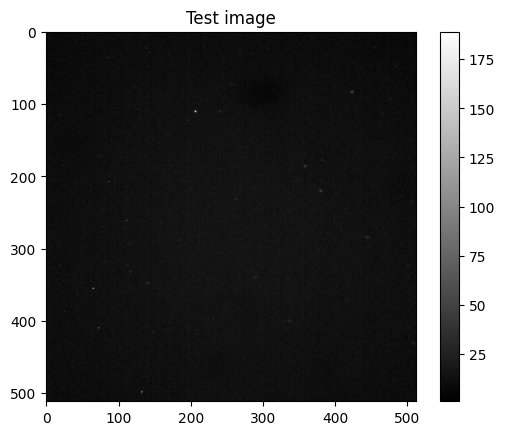

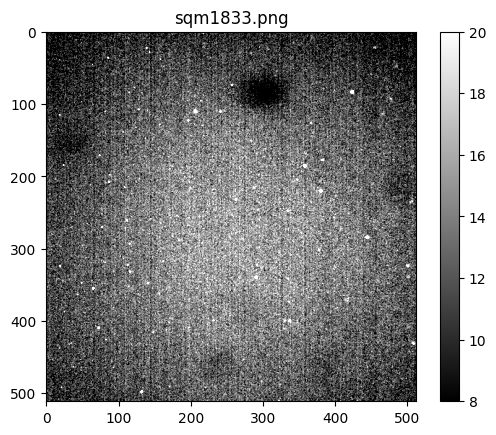

sqm1837.png


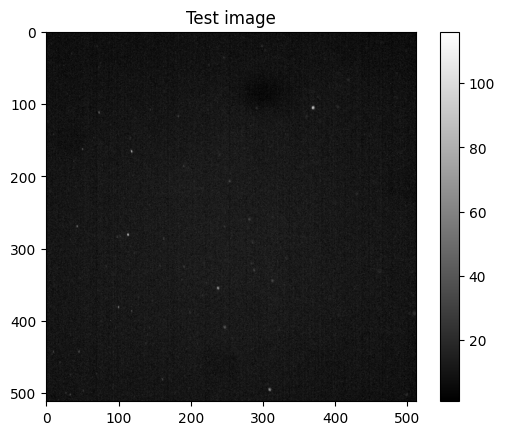

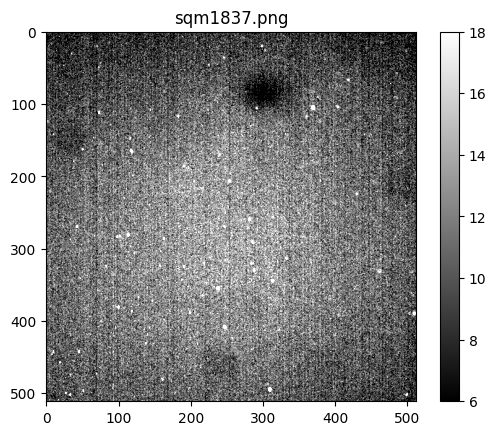

sqm1845.png


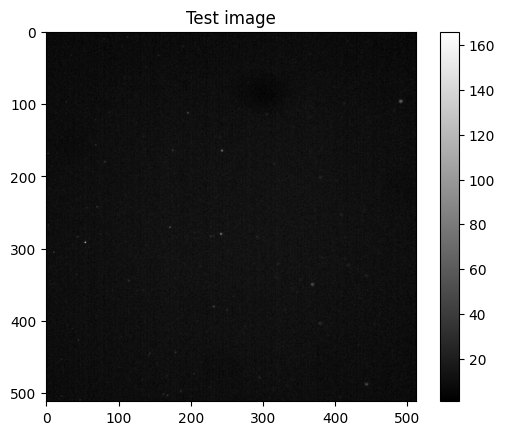

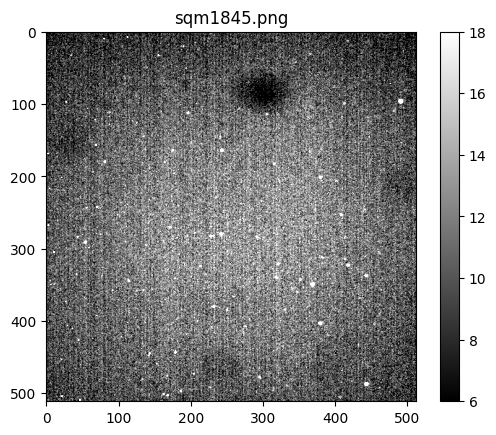

sqm1855.png


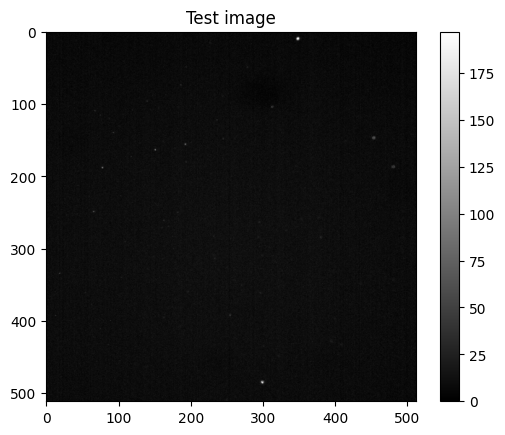

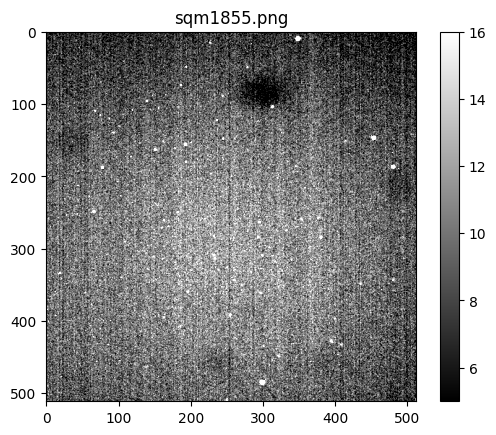

sqm1860.png


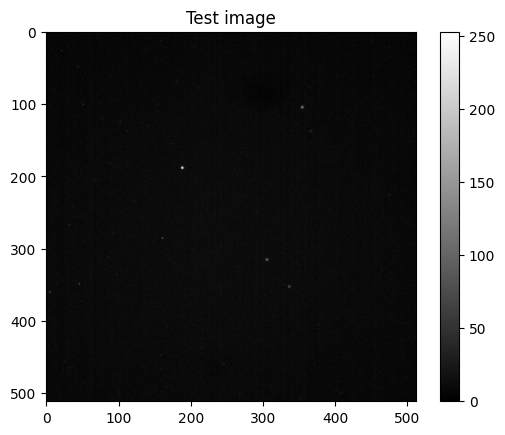

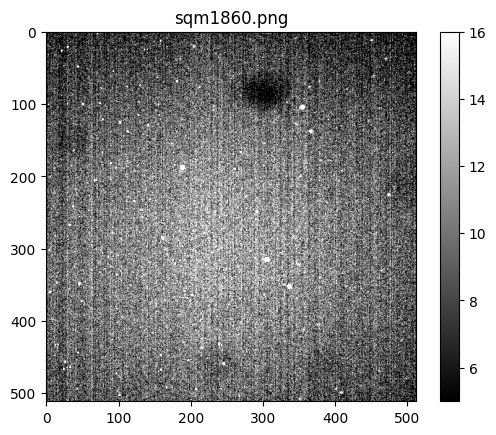

sqm1870.png


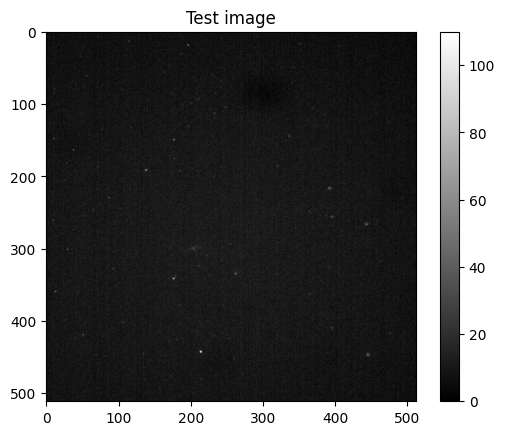

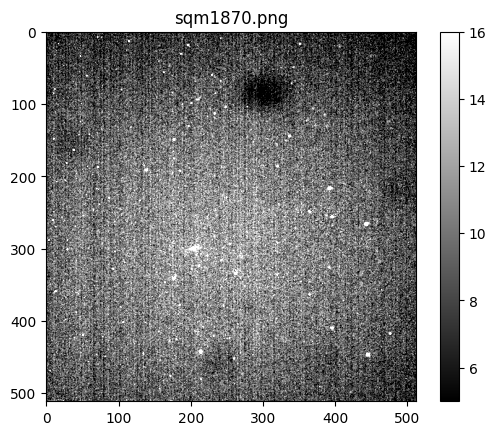

sqm1980.png


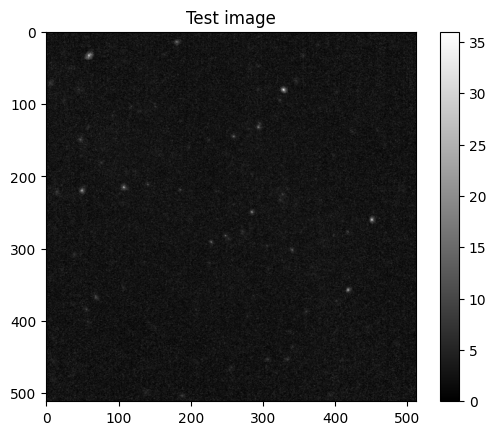

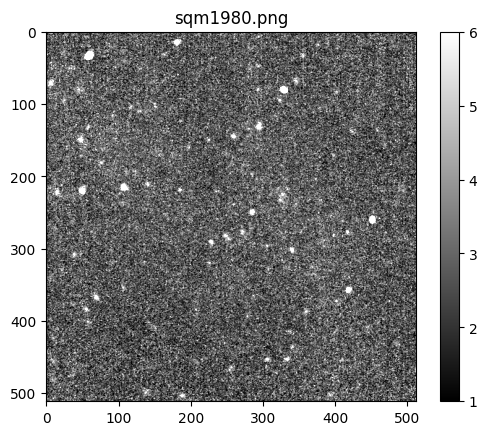

sqm2000_0.8-4.png


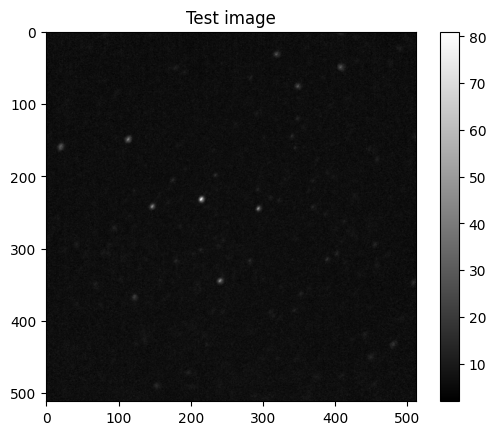

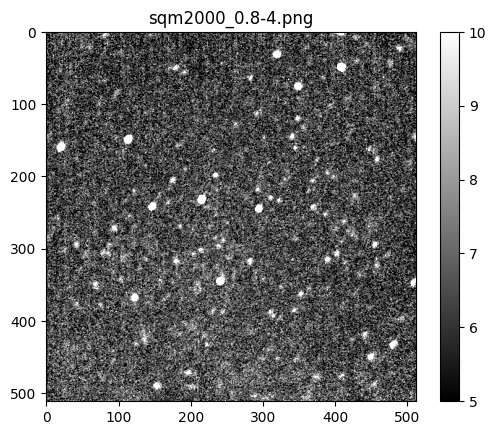

sqm2000_0.8-3.png


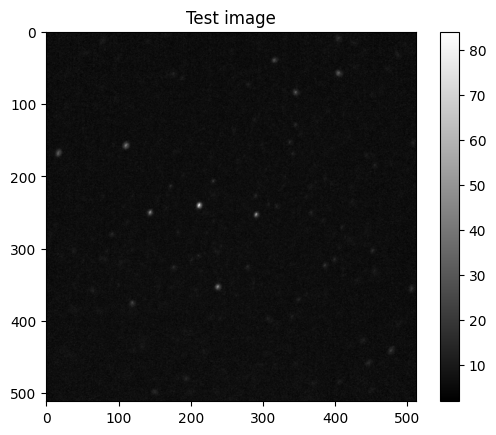

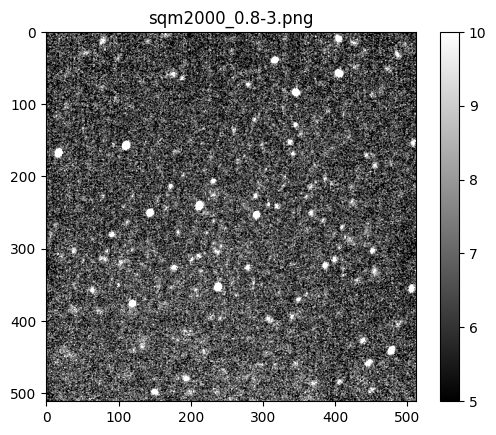

sqm1818_raw_new_0.2.png


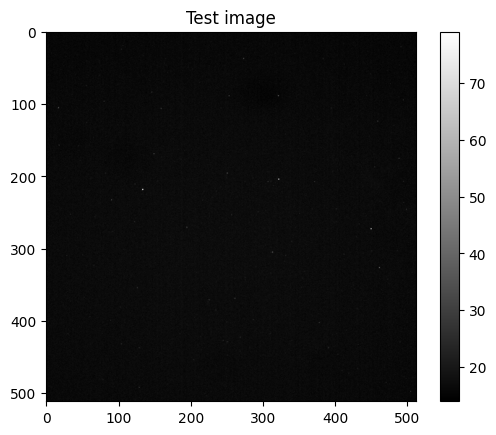

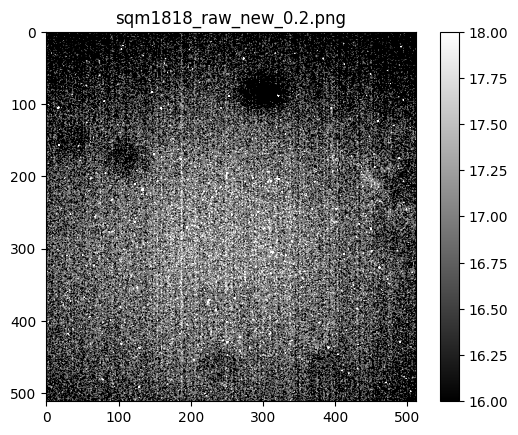

sqm1818_raw_new_1.png


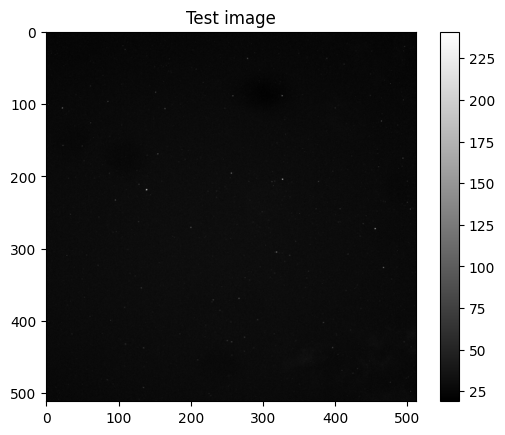

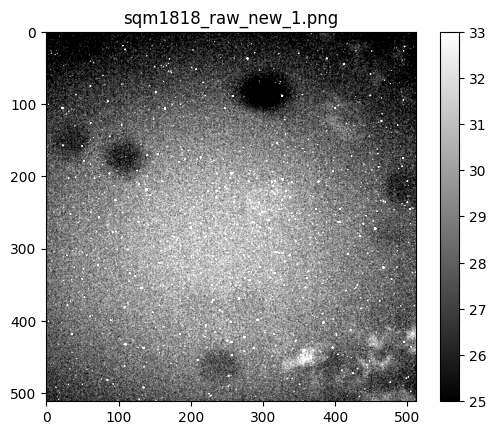

In [6]:
for filename in images:
    print(f"{filename}")
    np_image, image = load_image(filename)
    images[filename]['np_image'] = np_image
    show_image(np_image)
    percentile_stretch(np_image, filename)

### Cedar detect the image

In [7]:
def detect(np_image):
    centroids = cedar_detect.extract_centroids(
        np_image, sigma=8, max_size=10, use_binned=True
    )
    solution = t3.solve_from_centroids(
        centroids,
        (512, 512),
        fov_estimate=12.0,
        fov_max_error=4.0,
        match_max_error=0.005,
        return_matches=True,
        target_pixel=(128,128),
        solve_timeout=1000,
    )
    
    if "matched_centroids" in solution:
        # Don't clutter printed solution with these fields.
        # del solution['matched_centroids']
        # del solution['matched_stars']
        del solution["matched_catID"]
        del solution["pattern_centroids"]
        del solution["epoch_equinox"]
        del solution["epoch_proper_motion"]
        del solution["cache_hit_fraction"]
    return centroids, solution

for key, value in images.items():    
    centroids, solution = detect(value['np_image'])
    value['centroids'] = centroids  # Store ALL detected centroids
    value['matched_stars'] = solution['matched_stars']
    value['matched_centroids'] = solution['matched_centroids']
    value['fov'] = solution['FOV']
    print(f"For {key}, there are {len(value['matched_stars'])} matched_stars and {len(centroids)} total centroids")

For sqm1833.png, there are 21 matched_stars and 23 total centroids
For sqm1837.png, there are 15 matched_stars and 17 total centroids
For sqm1845.png, there are 19 matched_stars and 21 total centroids
For sqm1855.png, there are 17 matched_stars and 17 total centroids
For sqm1860.png, there are 18 matched_stars and 19 total centroids
For sqm1870.png, there are 23 matched_stars and 23 total centroids
For sqm1980.png, there are 18 matched_stars and 19 total centroids
For sqm2000_0.8-4.png, there are 21 matched_stars and 22 total centroids
For sqm2000_0.8-3.png, there are 29 matched_stars and 29 total centroids
For sqm1818_raw_new_0.2.png, there are 29 matched_stars and 34 total centroids
For sqm1818_raw_new_1.png, there are 71 matched_stars and 93 total centroids


### Created sorted matched arrays

In [8]:
def enhance_centroids(value: dict):
    matched_centroids = value['matched_centroids']
    matched_stars = value['matched_stars']
    xymags = []
    for centr, stars in zip(matched_centroids, matched_stars):
        xymags.append([*centr,*stars])
    xymags = np.array(xymags)
    xymags_sorted = xymags[xymags[:, 4].argsort()]
    # pixel_x, pixel_y - sorted
    matched_centroids_s = [[x[0], x[1]] for x in xymags_sorted]
    # ra, dec, mag - sorted
    matched_stars_s = [[x[2], x[3], x[4]] for x in xymags_sorted]
    # pixel_x, pixel_y, mag - sorted
    matched = [[x[0], x[1], x[4]] for x in xymags_sorted]
    value['matched_centroids'] = matched_centroids_s
    value['matched_stars'] = matched_stars_s
    value['matched'] = matched
    return value
    
for key, value in images.items():
    images[key] = enhance_centroids(value)

#pp.pprint(images)



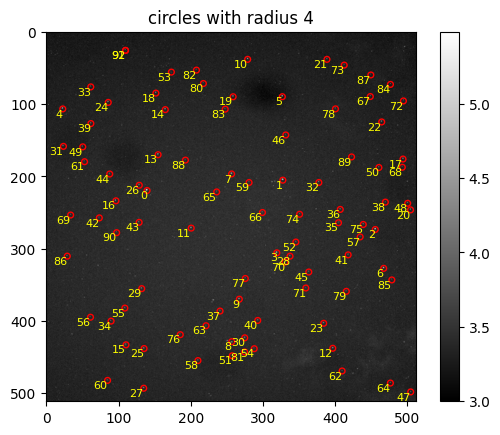

In [9]:
radius = 4
plt.title(f"circles with radius {radius}")
plt.imshow(np.log1p(np_image), cmap='gray')
plt.colorbar()
# Add circles
for i, (y, x) in enumerate(centroids):
    circle = plt.Circle((x, y), radius, fill=False, color='red')
    plt.gca().add_artist(circle)
     # Add number annotation
    plt.annotate(str(i), (x, y), color='yellow', fontsize=8, 
                ha='right', va='top')  # ha/va center the text on the point
plt.show()

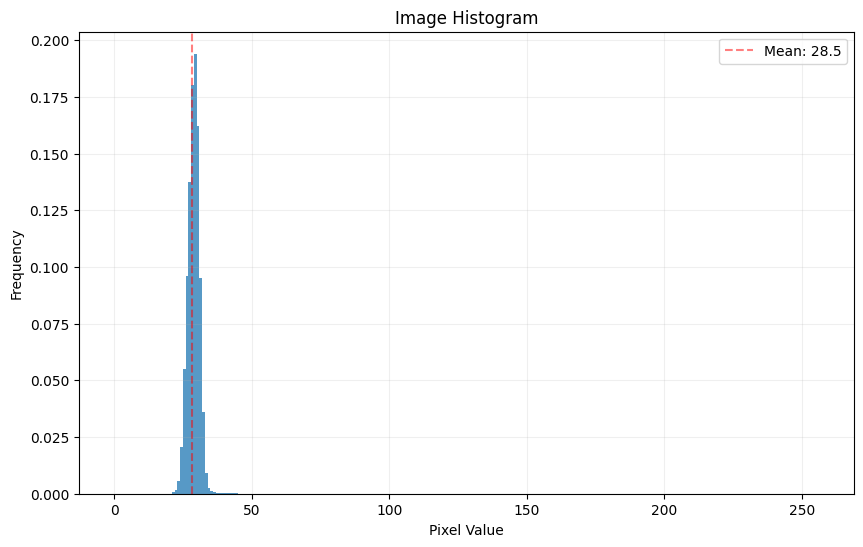

Min: 19
Max: 241
Mean: 28.45
Median: 29.00
Std Dev: 2.44


In [10]:
def histogram(image):
    # Method 1: Using PIL's built-in histogram
    hist = image.histogram()
    
    # Method 2: Better visualization with matplotlib
    np_image = np.array(image)
    
    plt.figure(figsize=(10, 6))
    plt.hist(np_image.ravel(), bins=256, range=(0, 256), density=True, alpha=0.75)
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')
    plt.title('Image Histogram')
    plt.grid(True, alpha=0.2)
    
    # Optional: Add vertical line for mean
    mean_val = np_image.mean()
    plt.axvline(mean_val, color='r', linestyle='dashed', alpha=0.5, 
                label=f'Mean: {mean_val:.1f}')
    plt.legend()
    
    plt.show()
    
    # Print some statistics
    print(f"Min: {np_image.min()}")
    print(f"Max: {np_image.max()}")
    print(f"Mean: {np_image.mean():.2f}")
    print(f"Median: {np.median(np_image):.2f}")
    print(f"Std Dev: {np_image.std():.2f}")
histogram(image)

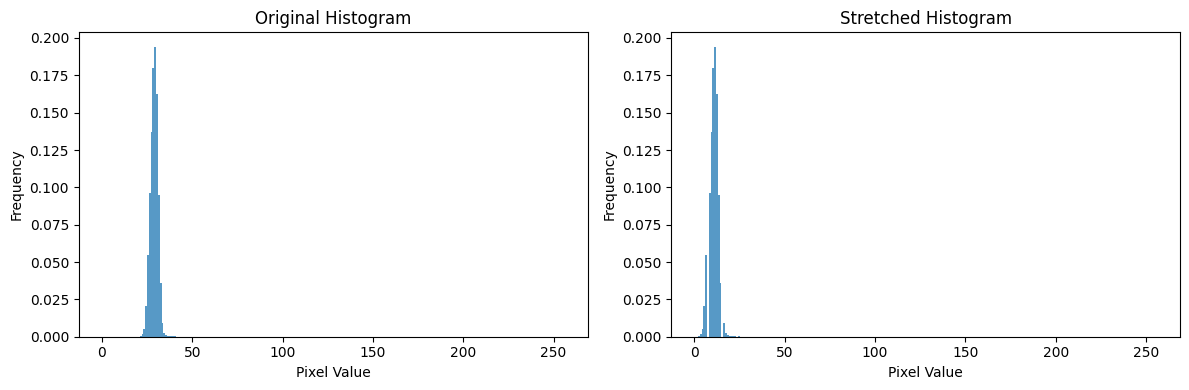

Original array:
Min: 19, Max: 241, Mean: 28.45

Stretched array:
Min: 0, Max: 255, Mean: 10.39


In [11]:
import matplotlib.pyplot as plt
import numpy as np

np_array = np_image
# Original histogram
plt.figure(figsize=(12, 4))

plt.subplot(121)
plt.hist(np_array.ravel(), bins=256, range=(0, 256), density=True, alpha=0.75)
plt.title('Original Histogram')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')

# Linear stretch (normalize to 0-255)
stretched = np_array.astype(float)
stretched = ((stretched - stretched.min()) * (255.0/(stretched.max() - stretched.min()))).astype(np.uint8)

plt.subplot(122)
plt.hist(stretched.ravel(), bins=256, range=(0, 256), density=True, alpha=0.75)
plt.title('Stretched Histogram')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Compare statistics
print("Original array:")
print(f"Min: {np_array.min()}, Max: {np_array.max()}, Mean: {np_array.mean():.2f}")
print("\nStretched array:")
print(f"Min: {stretched.min()}, Max: {stretched.max()}, Mean: {stretched.mean():.2f}")

In [12]:
# Test using production SQM implementation with local annulus backgrounds

# Parameters for local background measurement
APERTURE_RADIUS = 5  # Star flux aperture (pixels)
ANNULUS_INNER = 6    # Inner radius of background annulus (pixels)
ANNULUS_OUTER = 14   # Outer radius of background annulus (pixels)
ALTITUDE = 90        # Zenith for now (no extinction correction until we have real altitude)
PEDESTAL = 0         # No pedestal correction for now

print("Production SQM Implementation Results (Local Annulus Backgrounds)")
print("=" * 100)
print(f"{'Image':<25} {'Expected':<12} {'Calculated':<12} {'Error':<12} {'Error %':<12}")
print("-" * 100)

for key, value in images.items():
    # Build solution dict from the existing data
    solution = {
        'FOV': value['fov'],
        'matched_centroids': value['matched_centroids'],
        'matched_stars': value['matched_stars']
    }
    
    # Calculate SQM using local annulus backgrounds
    sqm_val, details = sqm.calculate(
        centroids=value['centroids'],
        solution=solution,
        image=value['np_image'], 
        altitude_deg=ALTITUDE,
        aperture_radius=APERTURE_RADIUS,
        annulus_inner_radius=ANNULUS_INNER,
        annulus_outer_radius=ANNULUS_OUTER,
        pedestal=PEDESTAL
    )
    
    if sqm_val is not None:
        value['sqm_calculated'] = sqm_val
        value['sqm_details'] = details
        
        expected = value['realsqm']
        calc_err = sqm_val - expected
        err_pct = 100 * calc_err / expected
        
        print(f"{key:<25} {expected:>10.2f}  {sqm_val:>10.2f}  {calc_err:>10.2f}  {err_pct:>10.1f}%")
        print(f"{'':>25} mzero={details['mzero']:>6.2f}, bg={details['background_per_pixel']:>6.1f} ADU/px, {details['n_matched_stars']} stars")
    else:
        print(f"{key:<25} FAILED")

print("=" * 100)

Production SQM Implementation Results (Local Annulus Backgrounds)
Image                     Expected     Calculated   Error        Error %     
----------------------------------------------------------------------------------------------------
sqm1833.png               FAILED
sqm1837.png               FAILED
sqm1845.png               FAILED
sqm1855.png               FAILED
sqm1860.png               FAILED
sqm1870.png               FAILED
sqm1980.png               FAILED
sqm2000_0.8-4.png         FAILED
sqm2000_0.8-3.png         FAILED
sqm1818_raw_new_0.2.png   FAILED
sqm1818_raw_new_1.png     FAILED


## Process All Test Images

Process the complete set of test images to validate the implementation.

In [13]:
# Process All Test Images - Using Production SQM

# Define all test images
all_images = {
    'sqm1833.png': {'realsqm': 18.33},
    'sqm1837.png': {'realsqm': 18.37},
    'sqm1845.png': {'realsqm': 18.45},
    'sqm1855.png': {'realsqm': 18.55},
    'sqm1860.png': {'realsqm': 18.60},
    'sqm1870.png': {'realsqm': 18.70},
    'sqm1980.png': {'realsqm': 19.80},
    'sqm2000_0.8-4.png': {'realsqm': 20.00},
    'sqm2000_0.8-3.png': {'realsqm': 20.00},
    'sqm1818_raw_new_0.2.png': {'realsqm': 18.18},    
    'sqm1818_raw_new_1.png': {'realsqm': 18.18}
}

# Parameters for local annulus background
APERTURE_RADIUS = 5
ANNULUS_INNER = 6
ANNULUS_OUTER = 14
ALTITUDE = 90
PEDESTAL = 0

# Process all images
print("Processing all test images...")
print("=" * 100)

results_summary = []

for filename, info in all_images.items():
    print(f"\nProcessing {filename}...")
    
    # Load image
    np_image, _ = load_image(filename)
    
    # Detect stars and solve
    centroids, solution = detect(np_image)
    
    # Check if solve succeeded
    if 'matched_centroids' not in solution or len(solution['matched_centroids']) == 0:
        print(f"  ❌ Failed to solve")
        results_summary.append({
            'filename': filename,
            'expected': info['realsqm'],
            'calculated': None,
            'error': None,
            'status': 'SOLVE_FAILED'
        })
        continue
    
    # Calculate SQM
    sqm_val, details = sqm.calculate(
        centroids=centroids,
        solution=solution,
        image=np_image,
        altitude_deg=ALTITUDE,
        aperture_radius=APERTURE_RADIUS,
        annulus_inner_radius=ANNULUS_INNER,
        annulus_outer_radius=ANNULUS_OUTER,
        pedestal=PEDESTAL
    )
    
    if sqm_val is not None:
        error = sqm_val - info['realsqm']
        print(f"  ✓ SQM: {sqm_val:.2f} (expected: {info['realsqm']:.2f}, error: {error:+.2f})")
        print(f"    mzero={details['mzero']:.2f}, stars={details['n_matched_stars']}, centroids={details['n_centroids']}")
        
        results_summary.append({
            'filename': filename,
            'expected': info['realsqm'],
            'calculated': sqm_val,
            'error': error,
            'mzero': details['mzero'],
            'n_stars': details['n_matched_stars'],
            'n_centroids': details['n_centroids'],
            'status': 'OK'
        })
    else:
        print(f"  ❌ Failed to calculate SQM")
        results_summary.append({
            'filename': filename,
            'expected': info['realsqm'],
            'calculated': None,
            'error': None,
            'status': 'CALC_FAILED'
        })

print("\n" + "=" * 100)
print("SUMMARY")
print("=" * 100)
print(f"{'Image':<30} {'Expected':<12} {'Calculated':<12} {'Error':<12} {'Status':<15}")
print("-" * 100)

for result in results_summary:
    if result['status'] == 'OK':
        print(f"{result['filename']:<30} {result['expected']:>10.2f}  {result['calculated']:>10.2f}  {result['error']:>10.2f}  {result['status']:<15}")
    else:
        print(f"{result['filename']:<30} {result['expected']:>10.2f}  {'---':>10}  {'---':>10}  {result['status']:<15}")

# Calculate statistics for successful measurements
successful = [r for r in results_summary if r['status'] == 'OK']
if successful:
    errors = [r['error'] for r in successful]
    print("\n" + "=" * 100)
    print("STATISTICS")
    print("=" * 100)
    print(f"Successful measurements: {len(successful)}/{len(results_summary)}")
    print(f"Mean error:              {np.mean(errors):+.2f} mag/arcsec²")
    print(f"Std dev:                 {np.std(errors):.2f} mag/arcsec²")
    print(f"RMS error:               {np.sqrt(np.mean(np.array(errors)**2)):.2f} mag/arcsec²")
    print(f"Max error:               {np.max(np.abs(errors)):.2f} mag/arcsec²")

Processing all test images...

Processing sqm1833.png...
  ❌ Failed to calculate SQM

Processing sqm1837.png...
  ❌ Failed to calculate SQM

Processing sqm1845.png...
  ❌ Failed to calculate SQM

Processing sqm1855.png...
  ❌ Failed to calculate SQM

Processing sqm1860.png...
  ❌ Failed to calculate SQM

Processing sqm1870.png...
  ❌ Failed to calculate SQM

Processing sqm1980.png...
  ❌ Failed to calculate SQM

Processing sqm2000_0.8-4.png...
  ❌ Failed to calculate SQM

Processing sqm2000_0.8-3.png...
  ❌ Failed to calculate SQM

Processing sqm1818_raw_new_0.2.png...
  ❌ Failed to calculate SQM

Processing sqm1818_raw_new_1.png...
  ❌ Failed to calculate SQM

SUMMARY
Image                          Expected     Calculated   Error        Status         
----------------------------------------------------------------------------------------------------
sqm1833.png                         18.33         ---         ---  CALC_FAILED    
sqm1837.png                         18.37         --

In [14]:
# Comprehensive Per-Image Diagnostics - Focus on mzero Calibration with Trendline Correction
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.gridspec import GridSpec
from scipy import stats

def sigma_clip_mean(data, sigma=2.0, max_iter=3):
    """Calculate mean after sigma clipping outliers. Returns mean, std, and mask matching input size."""
    data = np.array(data)
    original_indices = np.arange(len(data))
    mask = np.ones(len(data), dtype=bool)
    
    current_data = data.copy()
    current_indices = original_indices.copy()
    
    for _ in range(max_iter):
        mean = np.mean(current_data)
        std = np.std(current_data)
        keep = np.abs(current_data - mean) < sigma * std
        
        if np.sum(keep) == len(current_data):
            break
            
        current_data = current_data[keep]
        current_indices = current_indices[keep]
    
    # Create mask for original array
    final_mask = np.zeros(len(data), dtype=bool)
    final_mask[current_indices] = True
    
    return np.mean(current_data), np.std(current_data), final_mask

def detect_aperture_overlaps(star_centroids, aperture_radius, annulus_inner, annulus_outer):
    """
    Detect overlapping apertures and annuli between star pairs.
    
    Returns list of overlaps with format:
    {
        'star1_idx': int,
        'star2_idx': int,
        'distance': float,
        'type': str,  # 'CRITICAL', 'HIGH', 'MEDIUM'
        'description': str
    }
    """
    overlaps = []
    n_stars = len(star_centroids)
    
    for i in range(n_stars):
        for j in range(i+1, n_stars):
            x1, y1 = star_centroids[i]
            x2, y2 = star_centroids[j]
            distance = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
            
            # Check different overlap types
            if distance < 2 * aperture_radius:
                # CRITICAL: Aperture-aperture overlap (star flux contamination)
                overlaps.append({
                    'star1_idx': i,
                    'star2_idx': j,
                    'distance': distance,
                    'type': 'CRITICAL',
                    'description': f'Aperture overlap (d={distance:.1f}px < {2*aperture_radius}px)'
                })
            elif distance < aperture_radius + annulus_outer:
                # HIGH: Aperture inside another star's annulus (background contamination)
                overlaps.append({
                    'star1_idx': i,
                    'star2_idx': j,
                    'distance': distance,
                    'type': 'HIGH',
                    'description': f'Aperture-annulus overlap (d={distance:.1f}px < {aperture_radius + annulus_outer}px)'
                })
            elif distance < 2 * annulus_outer:
                # MEDIUM: Annulus-annulus overlap (less critical)
                overlaps.append({
                    'star1_idx': i,
                    'star2_idx': j,
                    'distance': distance,
                    'type': 'MEDIUM',
                    'description': f'Annulus overlap (d={distance:.1f}px < {2*annulus_outer}px)'
                })
    
    return overlaps

# Process each image with full diagnostics
for filename, info in all_images.items():
    print(f"\n{'='*100}")
    print(f"Processing: {filename}")
    print(f"Expected SQM: {info['realsqm']:.2f} mag/arcsec²")
    print(f"{'='*100}\n")
    
    # Load image
    np_image, _ = load_image(filename)
    
    # Detect stars and solve
    centroids, solution = detect(np_image)
    
    if 'matched_centroids' not in solution or len(solution['matched_centroids']) == 0:
        print(f"❌ Failed to solve {filename}\n")
        continue
    
    # Calculate SQM WITHOUT overlap correction
    sqm_val, details = sqm.calculate(
        centroids=centroids,
        solution=solution,
        image=np_image,
        altitude_deg=ALTITUDE,
        aperture_radius=APERTURE_RADIUS,
        annulus_inner_radius=ANNULUS_INNER,
        annulus_outer_radius=ANNULUS_OUTER,
        pedestal=PEDESTAL,
        correct_overlaps=False
    )
    
    # Calculate SQM WITH overlap correction
    sqm_val_corrected, details_corrected = sqm.calculate(
        centroids=centroids,
        solution=solution,
        image=np_image,
        altitude_deg=ALTITUDE,
        aperture_radius=APERTURE_RADIUS,
        annulus_inner_radius=ANNULUS_INNER,
        annulus_outer_radius=ANNULUS_OUTER,
        pedestal=PEDESTAL,
        correct_overlaps=True
    )
    
    if sqm_val is None:
        print(f"❌ Failed to calculate SQM for {filename}\n")
        continue
    
    # Extract details (use non-corrected for visualization, but we have both)
    star_centroids = np.array(details['star_centroids'])
    star_mags = details['star_mags']
    star_fluxes = details['star_fluxes']
    star_mzeros = details['star_mzeros']
    star_local_bgs = details.get('star_local_backgrounds', [None] * len(star_mags))
    
    # ========== APERTURE OVERLAP DETECTION ==========
    overlaps = detect_aperture_overlaps(star_centroids, APERTURE_RADIUS, ANNULUS_INNER, ANNULUS_OUTER)
    
    # Build set of stars affected by overlaps
    overlapping_stars = set()
    for overlap in overlaps:
        overlapping_stars.add(overlap['star1_idx'])
        overlapping_stars.add(overlap['star2_idx'])
    
    # Categorize overlaps by severity
    critical_overlaps = [o for o in overlaps if o['type'] == 'CRITICAL']
    high_overlaps = [o for o in overlaps if o['type'] == 'HIGH']
    medium_overlaps = [o for o in overlaps if o['type'] == 'MEDIUM']
    
    # Print overlap summary
    if overlaps:
        print(f"⚠️  OVERLAPS DETECTED: {len(overlaps)} total")
        print(f"   CRITICAL (aperture-aperture): {len(critical_overlaps)}")
        print(f"   HIGH (aperture-annulus):      {len(high_overlaps)}")
        print(f"   MEDIUM (annulus-annulus):     {len(medium_overlaps)}")
        print(f"   Stars affected: {len(overlapping_stars)}/{len(star_centroids)} ({100*len(overlapping_stars)/len(star_centroids):.0f}%)")
        print()
    else:
        print(f"✓ No aperture overlaps detected\n")
    
    # Calculate alternative mzero methods - filter for valid stars (flux > 0 and mzero not None)
    valid_indices = [i for i in range(len(star_fluxes)) 
                     if star_fluxes[i] > 0 and star_mzeros[i] is not None]
    valid_mzeros = np.array([star_mzeros[i] for i in valid_indices])
    valid_mags = np.array([star_mags[i] for i in valid_indices])
    valid_fluxes = np.array([star_fluxes[i] for i in valid_indices])
    
    
    if len(valid_mzeros) > 0:
        mzero_mean = np.mean(valid_mzeros)
        mzero_median = np.median(valid_mzeros)
        mzero_std = np.std(valid_mzeros)
        
        # Sigma clipping
        if len(valid_mzeros) >= 3:
            mzero_sigclip, mzero_sigclip_std, sigclip_mask = sigma_clip_mean(valid_mzeros, sigma=2.0)
            n_clipped = len(valid_mzeros) - np.sum(sigclip_mask)
        else:
            mzero_sigclip = mzero_mean
            mzero_sigclip_std = mzero_std
            n_clipped = 0
            sigclip_mask = np.ones(len(valid_mzeros), dtype=bool)
        
        # Trendline correction methods
        if len(valid_mzeros) >= 3:
            # Method 1: Trendline on all valid stars
            slope_all, intercept_all, r_value_all, _, _ = stats.linregress(valid_mags, valid_mzeros)
            # Evaluate trend at median magnitude
            median_mag = np.median(valid_mags)
            mzero_trend = slope_all * median_mag + intercept_all
            
            # Calculate residuals for quality metric
            predicted_all = slope_all * valid_mags + intercept_all
            residuals_all = valid_mzeros - predicted_all
            trend_rms_all = np.sqrt(np.mean(residuals_all**2))
            
            # Method 2: Sigma clip THEN fit trendline
            clipped_mags = valid_mags[sigclip_mask]
            clipped_mzeros = valid_mzeros[sigclip_mask]
            
            if len(clipped_mzeros) >= 3:
                slope_clip, intercept_clip, r_value_clip, _, _ = stats.linregress(clipped_mags, clipped_mzeros)
                median_mag_clip = np.median(clipped_mags)
                mzero_trend_sigclip = slope_clip * median_mag_clip + intercept_clip
                
                predicted_clip = slope_clip * clipped_mags + intercept_clip
                residuals_clip = clipped_mzeros - predicted_clip
                trend_rms_clip = np.sqrt(np.mean(residuals_clip**2))
            else:
                mzero_trend_sigclip = mzero_trend
                slope_clip = slope_all
                intercept_clip = intercept_all
                r_value_clip = r_value_all
                trend_rms_clip = trend_rms_all
        else:
            mzero_trend = mzero_mean
            mzero_trend_sigclip = mzero_sigclip
            slope_all = 0
            intercept_all = mzero_mean
            r_value_all = 0
            slope_clip = 0
            intercept_clip = mzero_sigclip
            r_value_clip = 0
            trend_rms_all = mzero_std
            trend_rms_clip = mzero_sigclip_std
        
        # Calculate SQM with alternative methods
        bg_flux_density = details['background_flux_density']
        extinction = details['extinction_correction']
        
        sqm_median = mzero_median - 2.5 * np.log10(bg_flux_density) + extinction
        sqm_sigclip = mzero_sigclip - 2.5 * np.log10(bg_flux_density) + extinction
        sqm_trend = mzero_trend - 2.5 * np.log10(bg_flux_density) + extinction
        sqm_trend_sigclip = mzero_trend_sigclip - 2.5 * np.log10(bg_flux_density) + extinction
    else:
        mzero_mean = mzero_median = mzero_sigclip = mzero_trend = mzero_trend_sigclip = None
        sqm_median = sqm_sigclip = sqm_trend = sqm_trend_sigclip = None
        n_clipped = 0
        slope_all = slope_clip = 0
        r_value_all = r_value_clip = 0
    
    # Create comprehensive figure with 4x3 grid
    fig = plt.figure(figsize=(24, 16))
    gs = GridSpec(4, 3, figure=fig, hspace=0.35, wspace=0.3)
    
    # ========== Panel 1: Image with apertures (spans 2x2) ==========
    ax1 = fig.add_subplot(gs[0:2, 0:2])
    
    # Display image with log stretch
    vmin, vmax = np.percentile(np_image, [1, 99.5])
    im = ax1.imshow(np_image, cmap='gray', vmin=vmin, vmax=vmax, origin='lower')
    
    # Draw connecting lines for overlaps FIRST (so they appear behind circles)
    for overlap in overlaps:
        x1, y1 = star_centroids[overlap['star1_idx']]
        x2, y2 = star_centroids[overlap['star2_idx']]
        
        # Color by severity
        if overlap['type'] == 'CRITICAL':
            line_color = 'red'
        elif overlap['type'] == 'HIGH':
            line_color = 'orange'
        else:
            line_color = 'yellow'
        
        ax1.plot([x1, x2], [y1, y2], color=line_color, linestyle=':', linewidth=2, alpha=0.7)
    
    # Draw apertures on matched stars
    for i, (centroid, flux, mag, local_bg) in enumerate(zip(star_centroids, star_fluxes, star_mags, star_local_bgs)):
        x, y = centroid
        
        # Color code by flux status, outlier detection, and overlap
        is_outlier = False
        if flux > 0 and mzero_mean is not None and len(star_mzeros) > i:
            mzero_val = star_mzeros[i]
            is_outlier = abs(mzero_val - mzero_mean) > 2.0 * mzero_std
        
        is_overlapping = i in overlapping_stars
        
        if flux <= 0:
            color = 'red'
            alpha = 0.8
        elif is_overlapping:
            color = 'magenta'  # Magenta for overlapping stars
            alpha = 0.8
        elif is_outlier:
            color = 'orange'
            alpha = 0.7
        else:
            color = 'lime'
            alpha = 0.6
        
        # Draw aperture circle (solid)
        circle = mpatches.Circle((x, y), APERTURE_RADIUS, 
                                 fill=False, edgecolor=color, linewidth=2, alpha=alpha)
        ax1.add_patch(circle)
        
        # Draw annulus inner (dashed)
        annulus_inner = mpatches.Circle((x, y), ANNULUS_INNER,
                                       fill=False, edgecolor=color, linewidth=1, 
                                       linestyle='--', alpha=0.4)
        ax1.add_patch(annulus_inner)
        
        # Draw annulus outer (dashed)
        annulus_outer_circle = mpatches.Circle((x, y), ANNULUS_OUTER,
                                       fill=False, edgecolor=color, linewidth=1, 
                                       linestyle='--', alpha=0.4)
        ax1.add_patch(annulus_outer_circle)
        
        # Label star
        label_text = f'{i}\nm={mag:.1f}\nf={flux:.0f}\nbg={local_bg:.0f}' if local_bg else f'{i}\nm={mag:.1f}'
        ax1.text(x + ANNULUS_OUTER + 3, y, label_text,
                color=color, fontsize=7, va='center', weight='bold',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='black', alpha=0.5))
    
    ax1.set_title(f'{filename}\nSQM: {sqm_val:.2f} (expected: {info["realsqm"]:.2f}, error: {sqm_val - info["realsqm"]:+.2f})',
                 fontsize=14, weight='bold')
    ax1.set_xlabel('X (pixels)', fontsize=11)
    ax1.set_ylabel('Y (pixels)', fontsize=11)
    plt.colorbar(im, ax=ax1, label='ADU')
    
    # Legend
    legend_elements = [
        mpatches.Patch(color='lime', label='Valid star'),
        mpatches.Patch(color='magenta', label='Overlapping'),
        mpatches.Patch(color='orange', label='Outlier (|Δmzero| > 2σ)'),
        mpatches.Patch(color='red', label='Bad flux (≤ 0)'),
        mpatches.Circle((0, 0), 1, fill=False, edgecolor='white', linewidth=2, label=f'Aperture (r={APERTURE_RADIUS}px)'),
        mpatches.Circle((0, 0), 1, fill=False, edgecolor='white', linewidth=1, linestyle='--', label=f'Annulus ({ANNULUS_INNER}-{ANNULUS_OUTER}px)')
    ]
    ax1.legend(handles=legend_elements, loc='upper right', fontsize=9)
    
    # ========== Panel 2: Per-Star Statistics Table ==========
    ax2 = fig.add_subplot(gs[0:2, 2])
    ax2.axis('off')
    
    # Build table data
    table_data = [['#', 'Mag', 'Flux\n(ADU)', 'Bg\n(ADU)', 'mzero', 'Δmz', 'OK']]
    for i, (mag, flux, local_bg, mzero) in enumerate(zip(star_mags, star_fluxes, star_local_bgs, star_mzeros)):
        status = '✓' if flux > 0 else '✗'
        delta_mzero = (mzero - mzero_mean) if (flux > 0 and mzero_mean) else None
        
        table_data.append([
            f'{i}',
            f'{mag:.2f}',
            f'{flux:.0f}',
            f'{local_bg:.0f}' if local_bg is not None else 'N/A',
            f'{mzero:.2f}' if flux > 0 else 'N/A',
            f'{delta_mzero:+.2f}' if delta_mzero is not None else 'N/A',
            status
        ])
    
    # Create table
    table = ax2.table(cellText=table_data, cellLoc='center', loc='center',
                     colWidths=[0.08, 0.12, 0.15, 0.12, 0.12, 0.10, 0.08])
    table.auto_set_font_size(False)
    table.set_fontsize(7)
    table.scale(1, 1.8)
    
    # Style header row
    for i in range(7):
        table[(0, i)].set_facecolor('#4CAF50')
        table[(0, i)].set_text_props(weight='bold', color='white')
    
    # Color code rows
    for i in range(1, len(table_data)):
        flux = star_fluxes[i-1]
        is_overlapping = (i-1) in overlapping_stars
        
        if flux <= 0:
            color = '#FFCDD2'  # Red
        elif is_overlapping:
            color = '#F8BBD0'  # Magenta/pink
        elif i-1 < len(star_mzeros) and mzero_mean is not None:
            delta = abs(star_mzeros[i-1] - mzero_mean)
            if delta > 2.0 * mzero_std:
                color = '#FFE0B2'  # Orange
            elif delta > 1.0 * mzero_std:
                color = '#FFF9C4'  # Yellow
            else:
                color = '#E8F5E9'  # Green
        else:
            color = 'white'
        
        for j in range(7):
            table[(i, j)].set_facecolor(color)
    
    ax2.set_title('Per-Star Breakdown\n(Δmz = deviation from mean)', fontsize=11, weight='bold', pad=20)
    
    # ========== Panel 3: mzero Values vs Magnitude with Trendlines ==========
    ax3 = fig.add_subplot(gs[2, 0])
    
    if len(valid_mzeros) > 0:
        # Scatter plot of individual mzero values
        colors = ['red' if not sigclip_mask[i] else 'blue' for i in range(len(valid_mzeros))]
        ax3.scatter(valid_mags, valid_mzeros, s=80, alpha=0.7, c=colors, edgecolors='black', linewidths=1, label='Stars', zorder=3)
        
        # Horizontal lines for different methods
        ax3.axhline(mzero_mean, color='blue', linestyle='-', linewidth=2, label=f'Mean: {mzero_mean:.3f}', alpha=0.6)
        ax3.axhline(mzero_median, color='green', linestyle='--', linewidth=2, label=f'Median: {mzero_median:.3f}', alpha=0.6)
        
        # Trendlines
        if len(valid_mzeros) >= 3:
            mag_range = np.array([valid_mags.min(), valid_mags.max()])
            
            # All stars trend
            trend_line_all = slope_all * mag_range + intercept_all
            ax3.plot(mag_range, trend_line_all, 'purple', linestyle='-.', linewidth=2.5, 
                    label=f'Trend (all): R²={r_value_all**2:.3f}', zorder=2)
            
            # Sigma-clipped trend
            if n_clipped > 0:
                trend_line_clip = slope_clip * mag_range + intercept_clip
                ax3.plot(mag_range, trend_line_clip, 'red', linestyle=':', linewidth=2.5, 
                        label=f'Trend (σ-clip): R²={r_value_clip**2:.3f}', zorder=2)
            
            # Mark median magnitude
            ax3.axvline(np.median(valid_mags), color='gray', linestyle='--', linewidth=1, alpha=0.5, zorder=1)
        
        # Std deviation bands
        ax3.axhspan(mzero_mean - mzero_std, mzero_mean + mzero_std, alpha=0.15, color='blue', zorder=0)
        
        ax3.set_xlabel('Catalog Magnitude', fontsize=10)
        ax3.set_ylabel('mzero', fontsize=10)
        ax3.set_title(f'mzero vs Magnitude\nσ = {mzero_std:.3f}, Trend slope = {slope_all:.4f}', fontsize=10, weight='bold')
        ax3.legend(fontsize=7, loc='best')
        ax3.grid(True, alpha=0.3)
        ax3.invert_xaxis()  # Brighter stars on right
    else:
        ax3.text(0.5, 0.5, 'No valid stars', transform=ax3.transAxes, ha='center', va='center')
    
    # ========== Panel 4: mzero Values vs Flux ==========
    ax4 = fig.add_subplot(gs[2, 1])
    
    if len(valid_mzeros) > 0:
        # Scatter plot of mzero vs log(flux)
        log_fluxes = np.log10(valid_fluxes)
        colors = ['red' if not sigclip_mask[i] else 'blue' for i in range(len(valid_mzeros))]
        ax4.scatter(log_fluxes, valid_mzeros, s=80, alpha=0.7, c=colors, edgecolors='black', linewidths=1)
        
        # Horizontal lines
        ax4.axhline(mzero_mean, color='blue', linestyle='-', linewidth=2, label=f'Mean', alpha=0.6)
        ax4.axhline(mzero_median, color='green', linestyle='--', linewidth=2, label=f'Median', alpha=0.6)
        
        # Check for trend with flux
        if len(valid_mzeros) >= 3:
            slope_flux, intercept_flux, r_value_flux, _, _ = stats.linregress(log_fluxes, valid_mzeros)
            if abs(r_value_flux) > 0.3:  # Significant correlation
                x_fit = np.array([log_fluxes.min(), log_fluxes.max()])
                y_fit = slope_flux * x_fit + intercept_flux
                ax4.plot(x_fit, y_fit, 'orange', linestyle=':', linewidth=2, 
                        label=f'Flux trend: R²={r_value_flux**2:.3f}')
        
        ax4.set_xlabel('log₁₀(Flux [ADU])', fontsize=10)
        ax4.set_ylabel('mzero', fontsize=10)
        ax4.set_title(f'mzero vs Flux\n(Should be flat if aperture correct)', fontsize=10, weight='bold')
        ax4.legend(fontsize=8, loc='best')
        ax4.grid(True, alpha=0.3)
    else:
        ax4.text(0.5, 0.5, 'No valid stars', transform=ax4.transAxes, ha='center', va='center')
    
    # ========== Panel 5: mzero Distribution Histogram ==========
    ax5 = fig.add_subplot(gs[2, 2])
    
    if len(valid_mzeros) > 0:
        # Histogram
        ax5.hist(valid_mzeros, bins=min(15, len(valid_mzeros)), 
                color='steelblue', alpha=0.7, edgecolor='black')
        
        # Mark different estimators
        ax5.axvline(mzero_mean, color='blue', linestyle='-', linewidth=2, label=f'Mean')
        ax5.axvline(mzero_median, color='green', linestyle='--', linewidth=2, label=f'Median')
        if n_clipped > 0:
            ax5.axvline(mzero_sigclip, color='red', linestyle='-.', linewidth=2, label=f'σ-clip')
        if len(valid_mzeros) >= 3:
            ax5.axvline(mzero_trend, color='purple', linestyle=':', linewidth=2, label=f'Trend')
        
        ax5.set_xlabel('mzero', fontsize=10)
        ax5.set_ylabel('Count', fontsize=10)
        ax5.set_title(f'mzero Distribution\nRange: [{np.min(valid_mzeros):.2f}, {np.max(valid_mzeros):.2f}]', 
                     fontsize=10, weight='bold')
        ax5.legend(fontsize=8)
        ax5.grid(True, alpha=0.3, axis='y')
    else:
        ax5.text(0.5, 0.5, 'No valid stars', transform=ax5.transAxes, ha='center', va='center')
    
    # ========== Panel 6: SQM Comparison Table with Overlap Correction ==========
    ax6 = fig.add_subplot(gs[3, 0])
    ax6.axis('off')
    
    # Compare different methods INCLUDING overlap-corrected
    comparison_data = [['Method', 'mzero', 'SQM', 'Error', 'Note']]
    
    if mzero_mean is not None:
        comparison_data.append([
            'Mean',
            f'{mzero_mean:.3f}',
            f'{sqm_val:.2f}',
            f'{sqm_val - info["realsqm"]:+.2f}',
            '← Current'
        ])
        comparison_data.append([
            'Median',
            f'{mzero_median:.3f}',
            f'{sqm_median:.2f}',
            f'{sqm_median - info["realsqm"]:+.2f}',
            ''
        ])
        if n_clipped > 0:
            comparison_data.append([
                'σ-clipped',
                f'{mzero_sigclip:.3f}',
                f'{sqm_sigclip:.2f}',
                f'{sqm_sigclip - info["realsqm"]:+.2f}',
                f'-{n_clipped} star'
            ])
        if len(valid_mzeros) >= 3:
            comparison_data.append([
                'Trend (all)',
                f'{mzero_trend:.3f}',
                f'{sqm_trend:.2f}',
                f'{sqm_trend - info["realsqm"]:+.2f}',
                f'R²={r_value_all**2:.2f}'
            ])
            if n_clipped > 0:
                comparison_data.append([
                    'Trend+σ-clip',
                    f'{mzero_trend_sigclip:.3f}',
                    f'{sqm_trend_sigclip:.2f}',
                    f'{sqm_trend_sigclip - info["realsqm"]:+.2f}',
                    f'R²={r_value_clip**2:.2f}'
                ])
        
        # Add overlap-corrected result
        if sqm_val_corrected is not None and details_corrected.get('n_stars_excluded_overlaps', 0) > 0:
            n_excl = details_corrected['n_stars_excluded_overlaps']
            comparison_data.append([
                'Overlap-corrected',
                f'{details_corrected["mzero"]:.3f}',
                f'{sqm_val_corrected:.2f}',
                f'{sqm_val_corrected - info["realsqm"]:+.2f}',
                f'-{n_excl} overlap'
            ])
        
        comparison_data.append([
            'Expected',
            '—',
            f'{info["realsqm"]:.2f}',
            '0.00',
            'Target'
        ])
    
    comp_table = ax6.table(cellText=comparison_data, cellLoc='center', loc='center',
                          colWidths=[0.23, 0.18, 0.15, 0.15, 0.29])
    comp_table.auto_set_font_size(False)
    comp_table.set_fontsize(8)
    comp_table.scale(1, 2.2)
    
    # Style header
    for i in range(5):
        comp_table[(0, i)].set_facecolor('#2196F3')
        comp_table[(0, i)].set_text_props(weight='bold', color='white')
    
    # Highlight best method
    if len(comparison_data) > 2:
        errors = [abs(float(row[3])) for row in comparison_data[1:-1]]
        best_idx = np.argmin(errors) + 1
        for j in range(5):
            comp_table[(best_idx, j)].set_facecolor('#C8E6C9')
    
    ax6.set_title('mzero Method Comparison', fontsize=11, weight='bold', pad=20)
    
    # ========== Panel 7: Background Annuli ==========
    ax7 = fig.add_subplot(gs[3, 1])
    
    # Create visualization showing annulus regions
    height, width = np_image.shape
    y, x = np.ogrid[:height, :width]
    annulus_mask_img = np.zeros((height, width), dtype=bool)
    for centroid in star_centroids:
        cx, cy = centroid
        dist_sq = (x - cx)**2 + (y - cy)**2
        star_annulus = (dist_sq > ANNULUS_INNER**2) & (dist_sq <= ANNULUS_OUTER**2)
        annulus_mask_img |= star_annulus
    
    annulus_display = np.where(annulus_mask_img, np_image, np.nan)
    ax7.imshow(annulus_display, cmap='viridis', vmin=vmin, vmax=vmax, origin='lower')
    ax7.set_title(f'Background Annuli\n(median={details["background_per_pixel"]:.1f} ADU)', 
                 fontsize=10, weight='bold')
    ax7.set_xlabel('X (pixels)', fontsize=9)
    ax7.set_ylabel('Y (pixels)', fontsize=9)
    
    # ========== Panel 8: Calculation Summary with Overlap Info ==========
    ax8 = fig.add_subplot(gs[3, 2])
    ax8.axis('off')
    
    # Find best method
    if mzero_mean is not None:
        methods = ['Mean', 'Median', 'σ-clip', 'Trend', 'Trend+σ-clip', 'Overlap-corrected']
        sqm_values = [sqm_val, sqm_median, sqm_sigclip, sqm_trend, sqm_trend_sigclip, sqm_val_corrected]
        errors = [abs(sqm - info['realsqm']) for sqm in sqm_values if sqm is not None]
        valid_methods = [m for m, sqm in zip(methods, sqm_values) if sqm is not None]
        if errors:
            best_method = valid_methods[np.argmin(errors)]
        else:
            best_method = 'Mean'
    else:
        best_method = 'N/A'
    
    corrected_str = f"{sqm_val_corrected:.2f}" if sqm_val_corrected is not None else "N/A"
    error_str = f"{sqm_val_corrected - info['realsqm']:+.2f}" if sqm_val_corrected is not None else "N/A"

    summary_text = f"""CALCULATION SUMMARY
{'='*35}

Stars: {details['n_matched_stars']} matched
       {details['n_centroids']} total centroids

OVERLAPS: {len(overlaps)} total
  CRITICAL:  {len(critical_overlaps)}
  HIGH:      {len(high_overlaps)}
  MEDIUM:    {len(medium_overlaps)}
  Affected:  {len(overlapping_stars)}/{len(star_centroids)}

Background: Local annuli
  Aperture: {APERTURE_RADIUS} px
  Annulus: {ANNULUS_INNER}-{ANNULUS_OUTER} px
  Sky: {details['background_per_pixel']:.2f} ADU/px

mzero Statistics:
  Mean:      {mzero_mean:.3f} ± {mzero_std:.3f}
  Median:    {mzero_median:.3f}
  σ-clipped: {mzero_sigclip:.3f}
  Trend:     {mzero_trend:.3f}
  Trend+σ:   {mzero_trend_sigclip:.3f}
  Outliers:  {n_clipped}/{len(valid_mzeros)}

Trend Analysis:
  Slope:     {slope_all:.4f} mag/mag
  R²:        {r_value_all**2:.4f}
  Sig?       {'YES' if abs(r_value_all) > 0.5 else 'NO'}

SQM Results:
  Without overlap correction:
    Current:   {sqm_val:.2f} mag/arcsec²
    Error:     {sqm_val - info['realsqm']:+.2f}
  
  With overlap correction:
    Corrected: {corrected_str} mag/arcsec²
    Error:     {error_str}
    Excluded:  {details_corrected.get('n_stars_excluded_overlaps', 0)} stars

Expected:    {info['realsqm']:.2f}

Best Method: {best_method}
"""
    
    ax8.text(0.05, 0.95, summary_text, 
            transform=ax8.transAxes, fontsize=7.5, 
            verticalalignment='top', fontfamily='monospace',
            bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed overlap information
    if overlaps:
        print(f"\nDETAILED OVERLAP INFORMATION:")
        print(f"{'='*100}")
        for overlap in overlaps:
            i, j = overlap['star1_idx'], overlap['star2_idx']
            print(f"  [{overlap['type']:8}] Stars {i} ↔ {j}: {overlap['description']}")
            print(f"              Star {i}: mag={star_mags[i]:.2f}, flux={star_fluxes[i]:.0f} ADU")
            print(f"              Star {j}: mag={star_mags[j]:.2f}, flux={star_fluxes[j]:.0f} ADU")
        print(f"{'='*100}\n")
    
    # Print summary
    print(f"\n✓ Processed {filename}")
    print(f"\n  WITHOUT overlap correction:")
    print(f"    SQM (mean):           {sqm_val:.2f} (error: {sqm_val - info['realsqm']:+.2f})")
    print(f"    SQM (median):         {sqm_median:.2f} (error: {sqm_median - info['realsqm']:+.2f})")
    print(f"    SQM (σ-clipped):      {sqm_sigclip:.2f} (error: {sqm_sigclip - info['realsqm']:+.2f})")
    print(f"    SQM (trend):          {sqm_trend:.2f} (error: {sqm_trend - info['realsqm']:+.2f})")
    print(f"    SQM (trend+σ-clip):   {sqm_trend_sigclip:.2f} (error: {sqm_trend_sigclip - info['realsqm']:+.2f})")
    
    if sqm_val_corrected is not None:
        print(f"\n  WITH overlap correction:")
        print(f"    SQM (overlap-corr):   {sqm_val_corrected:.2f} (error: {sqm_val_corrected - info['realsqm']:+.2f})")
        print(f"    Stars excluded:       {details_corrected.get('n_stars_excluded_overlaps', 0)}/{details_corrected.get('n_matched_stars_original', 0)}")
        print(f"    Improvement:          {(sqm_val_corrected - sqm_val):+.2f} mag/arcsec²")
    
    print(f"\n  Trend: slope={slope_all:.4f}, R²={r_value_all**2:.4f}")
    print(f"  Best method: {best_method}")
    
    # Flag issues
    issues = []
    if any(f <= 0 for f in star_fluxes):
        n_negative = sum(1 for f in star_fluxes if f <= 0)
        issues.append(f"⚠️  {n_negative} stars with negative/zero flux")
    if mzero_std > 0.3:
        issues.append(f"⚠️  High mzero scatter: {mzero_std:.3f}")
    if abs(r_value_all) > 0.5:
        issues.append(f"⚠️  Significant magnitude trend: R²={r_value_all**2:.3f}")
    if abs(sqm_val - info['realsqm']) > 0.5:
        issues.append(f"⚠️  Large error (no corr): {sqm_val - info['realsqm']:+.2f} mag/arcsec²")
    if n_clipped > 0:
        issues.append(f"ℹ️  {n_clipped} outliers removed by σ-clipping")
    if overlaps:
        issues.append(f"⚠️  {len(overlaps)} aperture overlaps detected ({len(overlapping_stars)} stars affected)")
    
    if issues:
        print(f"\n  Notes:")
        for issue in issues:
            print(f"  {issue}")
    
    print("")



Processing: sqm1833.png
Expected SQM: 18.33 mag/arcsec²



❌ Failed to calculate SQM for sqm1833.png


Processing: sqm1837.png
Expected SQM: 18.37 mag/arcsec²



❌ Failed to calculate SQM for sqm1837.png


Processing: sqm1845.png
Expected SQM: 18.45 mag/arcsec²

❌ Failed to calculate SQM for sqm1845.png


Processing: sqm1855.png
Expected SQM: 18.55 mag/arcsec²



❌ Failed to calculate SQM for sqm1855.png


Processing: sqm1860.png
Expected SQM: 18.60 mag/arcsec²

❌ Failed to calculate SQM for sqm1860.png


Processing: sqm1870.png
Expected SQM: 18.70 mag/arcsec²

❌ Failed to calculate SQM for sqm1870.png


Processing: sqm1980.png
Expected SQM: 19.80 mag/arcsec²

❌ Failed to calculate SQM for sqm1980.png


Processing: sqm2000_0.8-4.png
Expected SQM: 20.00 mag/arcsec²

❌ Failed to calculate SQM for sqm2000_0.8-4.png


Processing: sqm2000_0.8-3.png
Expected SQM: 20.00 mag/arcsec²

❌ Failed to calculate SQM for sqm2000_0.8-3.png


Processing: sqm1818_raw_new_0.2.png
Expected SQM: 18.18 mag/arcsec²

❌ Failed to calculate SQM for sqm1818_raw_new_0.2.png


Processing: sqm1818_raw_new_1.png
Expected SQM: 18.18 mag/arcsec²

❌ Failed to calculate SQM for sqm1818_raw_new_1.png

